## 集成

某种意义上，孔多塞陪审团定理形象的描述了上面提到的集成概念。该定理的内容为：如果评审团的每个成员做出独立判断，并且每个陪审员做出正确决策的概率高于 0.5，那么整个评审团做出正确的总体决策的概率随着陪审员数量的增加而增加，并趋向于一。另一方面，如果每个陪审员判断正确的概率小于 0.5，那么整个陪审团做出正确的总体决策的概率随着陪审员数量的增加而减少，并趋向于零。

整个评审团做出正确决策的概率公式为：

$$ \mu = \sum_{i=m}^{N} \binom{N}{i} p^i (1 - p)^{N-i} $$  

其中：  
- $ N $ 表示陪审员总数
- $ m = \lfloor (N/2) + 1 \rfloor $ 是构成多数的最小值‌:  
- $ \binom{N}{i} $ 表示组合数
- $ p $ 是单个陪审员做出正确决策的概率‌
- $ \mu $ 为最终正确决策概率‌        

由上式可知，若$p>0.5$,则$u>p$,此外，若$n→∞$,则$μ→1$


# Bootstrapping

Leo Breiman 于 1994 年提出的 Bagging（又称 Bootstrap Aggregation，引导聚集）是最基本的集成技术之一。Bagging 基于统计学中的 Bootstraping（自助法），该方法令复杂模型的统计评估变得更加可行。

Bootstrap 方法的流程如下：假设有尺寸为 N 的样本 X，从该样本中有放回地随机抽取 N 个样本，以创建一个新样本。换句话说，从尺寸为 N 的原样本中随机选择一个元素，并重复此过程 N 次。选中所有元素的可能性是一样的，因此每个元素被抽中的概率均为$1/N$

假设用 Bootstrap 方法从一个袋子中抽球，每次抽一个。在每一步中，将选中的球放回袋子，这样下一次抽取是等概率的，即，从同样数量的 N 个球中抽取。注意，因为我们把球放回了，新样本中可能有重复的球。把这个新样本称为$X1$。重复这一过程 M 次，创建 M 个 Bootstrap 样本$X_1，....X_M$。最后，我们的样本数量就从原先的 1 个扩充到了 M 个，就有充足的样本来计算原始分布的多种统计数据。


 

In [117]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline
warnings.filterwarnings('ignore')

看一个例子，这个例子使用之前的 telecom_churn 数据集。我们曾讨论过这一数据集的特征重要性，其中最重要的特征之一是呼叫客服次数（Customer service calls）。可视化「呼叫客服次数」这一特征，看看其分布。

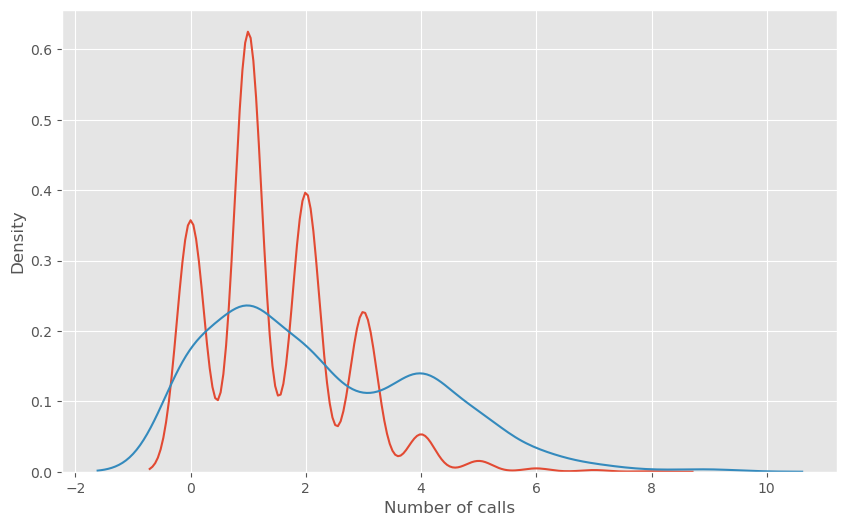

In [118]:
telecom_data = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == True]['Customer service calls'], label='Churn')
fig.set(xlabel='Number of calls', ylabel='Density')
plt.show()

In [119]:
telecom_data

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [120]:
# 定义 get_bootstrap_samples() 函数产生 Bootstrap 样本，
# 定义 stat_intervals() 函数产生一个区间估计。
def get_booststrap_samples(data,n_samples):
    indices = np.random.randint(0,len(data),(n_samples,len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

"""
numpy.percentile(a, q, axis=None, out=None,
overwrite_input=False, interpolation='linear', keepdims=False)
沿指定轴计算数据的第q个百分位数。
返回数组元素的第q个百分位数。
我们可以使用np.percentile()来计算单一百分位数的值。
例如,计算第50个百分位数(即中位数),跟顺序无关
"""


"\nnumpy.percentile(a, q, axis=None, out=None,\noverwrite_input=False, interpolation='linear', keepdims=False)\n沿指定轴计算数据的第q个百分位数。\n返回数组元素的第q个百分位数。\n我们可以使用np.percentile()来计算单一百分位数的值。\n例如,计算第50个百分位数(即中位数),跟顺序无关\n"


 **高级索引**
   - 如果 `indices` 是一个二维数组（形状为 `(n_samples, len(data))`），则 `data[indices]` 的输出形状会与 `indices` 的形状一致。
   - **示例**：
     ```python
     data = np.array([10, 20, 30, 40, 50])
     indices = np.array([[0, 1, 1, 3, 4], [2, 2, 4, 0, 1]])
     samples = data[indices]
     ```
     输出 `samples` 的形状为 `(2, 5)`，即：
     ```python
     [[10, 20, 20, 40, 50],  # 对应 indices 的第一行 [0,1,1,3,4]
      [30, 30, 50, 10, 20]]  # 对应 indices 的第二行 [2,2,4,0,1]
     ```


In [121]:
# 分割数据集，分组为忠实客户和离网客户。
loyal_calls = telecom_data.loc[telecom_data['Churn'] == False,
                               'Customer service calls'].values
churn_calls = telecom_data.loc[telecom_data['Churn'] == True,
                               'Customer service calls'].values

# df[i,j] 第i行，第j列
# [telecom_data['Churn'] == False,'Customer service calls'].values
# 获得 telecom_data['Churn'] == False的行,Customer service calls
# 如果不加.values，获得的行和值


In [122]:
np.random.seed(0)

In [123]:
# 使用 Bootstrap 生成样本，计算各自的均值。

loyal_mean_scores = [np.mean(sample) 
                     for sample in get_booststrap_samples(loyal_calls,1000)]
churn_mean_scores = [np.mean(sample)
                     for sample in get_booststrap_samples(churn_calls,1000)]


In [124]:
# 打印区间估计值，使用 stat_intervals() 函数将区间定义为 95%。
print("Service calls from loyal: mean interval",
      stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn: mean interval",
      stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


# Bagging


理解了 Bootstrap 概念之后，接下来介绍 Bagging。

假设我们有一个训练集 X。我们使用 Bootstrap 生成样本$X_1,...,X_M$。现在，我们在每个 Bootstrap 样本上分别训练分类器$a_i(x)$最终的分类器将对所有这些单独的分类器的输出取均值。在分类情形下，这种技术即投票（voting）：$$
a(x) = \frac{1}{M}\sum_{i=1}^M a_i(x).$$

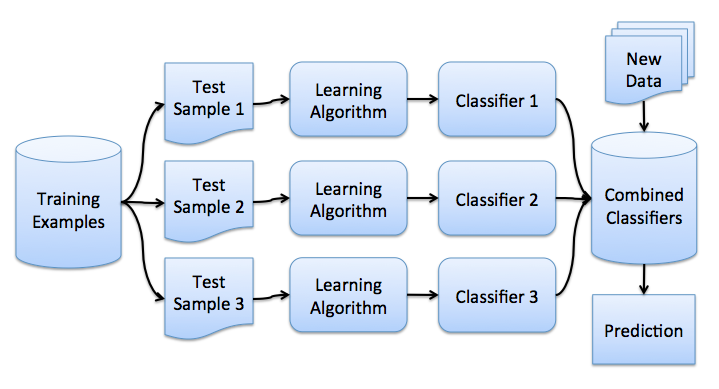

在回归问题中，通过对回归结果取均值，Bagging 将均方误差降至$1/M$
回顾一下上一课的内容，模型的预测误差由三部分构成：
$$
\text{Bias}\left( f \right)^2 + V_{\mathrm{ar}}\left( f \right) + \sigma^2
$$

Bagging 通过在不同数据集上训练模型的方式来降低分类器的方差。换句话说，Bagging 可以预防过拟合。由于来自不同训练数据集上的模型各不相同，它们的误差在投票过程中会相互抵消，所以 Bagging 是有效的。此外，某些 Bootstrap 训练样本很可能会忽略异常值。

# 随机森林

**随机森林与 Bagging 和决策树的比较**



In [125]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

n_train = 150
n_test = 1000
noise = 0.1

In [126]:
# 生成数据
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


In [127]:
def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y
X_train,y_train = generate(n_samples=n_train,noise= noise)
X_test,y_test = generate(n_samples = n_test,noise=noise)

Text(0.5, 1.0, 'Decision tree, MSE = 20.09')

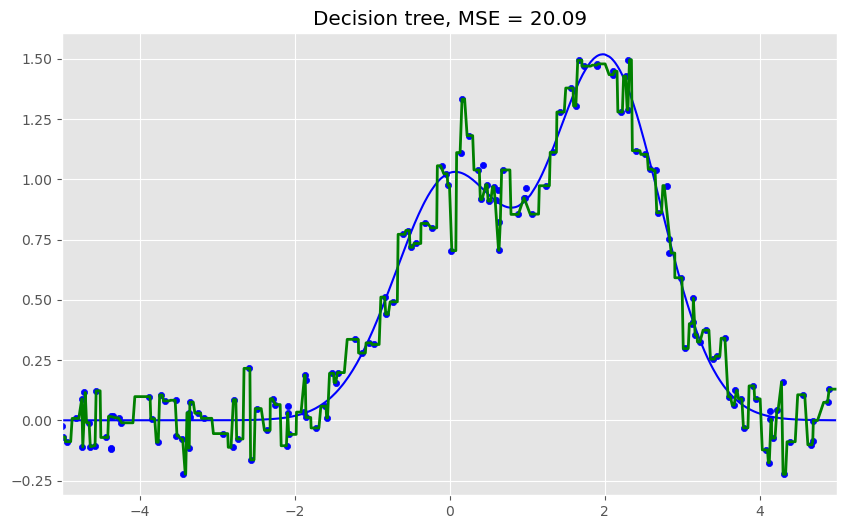

In [128]:
# 使用单棵决策树回归。
dtree = DecisionTreeRegressor().fit(X_train,y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test,f(X_test),'b')
plt.scatter(X_train,y_train,c='b',s=20) # s 圆点的面积
plt.plot(X_test,d_predict,"g",lw =2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f"
          % np.sum((y_test - d_predict) ** 2))

Text(0.5, 1.0, 'Bagging for decision trees, MSE = 15.12')

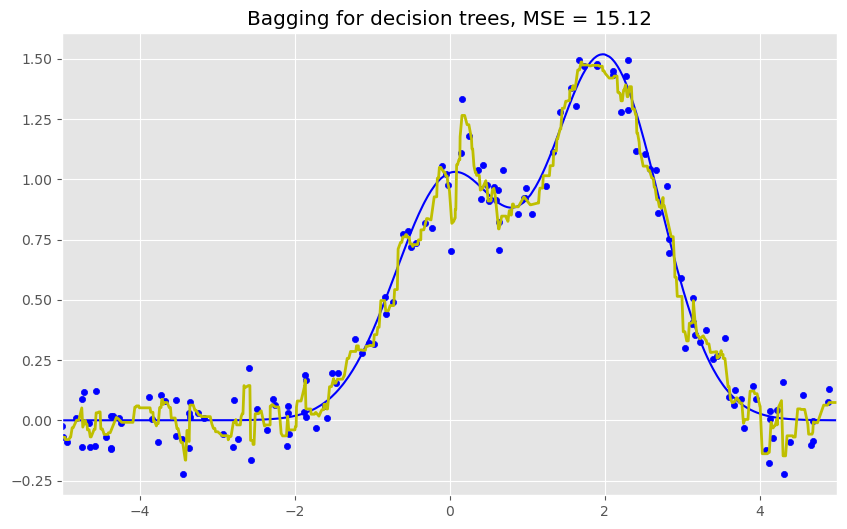

In [129]:
# 使用 Bagging 决策树回归。
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train,y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test,f(X_test),'b')
plt.scatter(X_train,y_train,c = 'b',s = 20 )
plt.plot(X_test,bdt_predict,'y',lw = 2)
plt.xlim([-5,5])
plt.title("Bagging for decision trees, MSE = %.2f" %
          np.sum((y_test - bdt_predict) ** 2))

Text(0.5, 1.0, 'Random forest, MSE = 15.71')

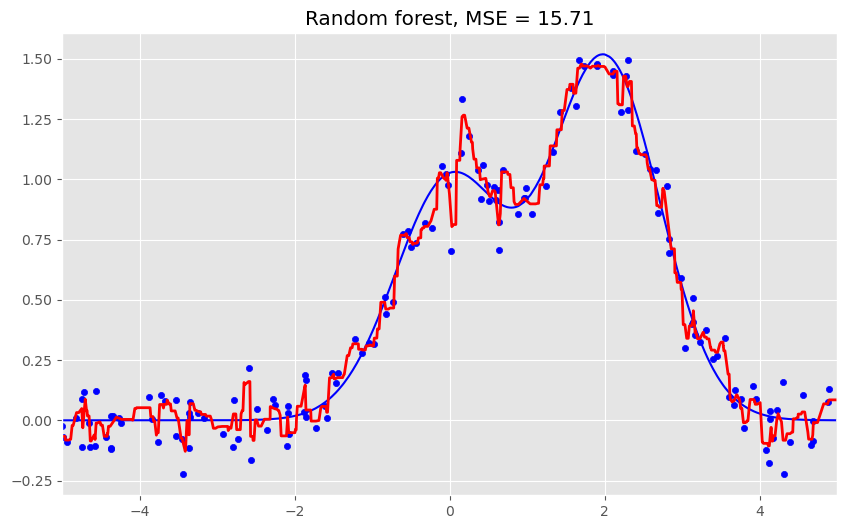

In [130]:
# 使用随机森林。
rf  = RandomForestRegressor(n_estimators=10).fit(X_train,y_train)
rf_pre = rf.predict(X_test)
plt.figure(figsize = (10,6))
plt.plot(X_test,f(X_test),"b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_pre, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_pre) ** 2))

接下来，我们将查看随机森林和 Bagging 在分类问题上的表现。



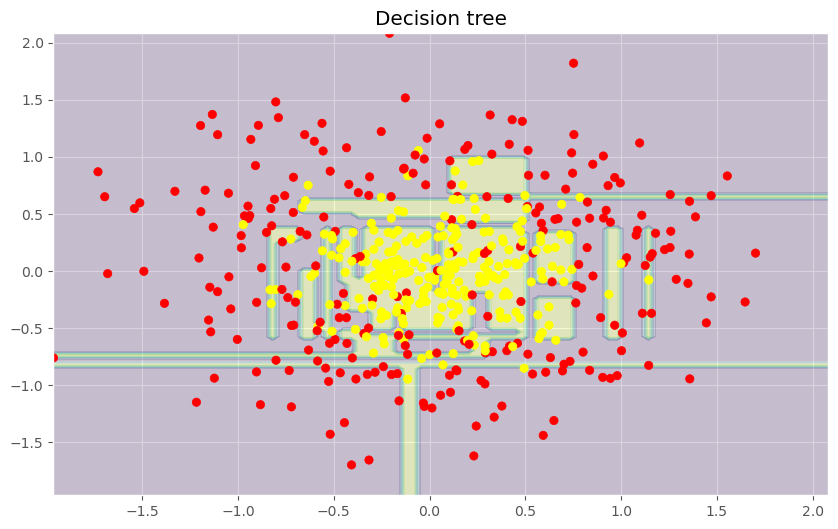

In [131]:
np.random.seed(42)
X,y = make_circles(n_samples = 500,factor=0.1,noise=0.35,random_state = 42)
X_train_circles,X_test_circles,y_train_circles,y_test_circles = train_test_split(X,y,test_size=0.2)
# plt.figure(figsize=(6,6))
# plt.scatter(X[:,0],X[:,1])
# 返回值：
#     X：[n_samples, 2]形状的数组，生成的样本
#     Y：[n_samples]形状的数组，每个样本的标签（0或1）

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles,y_train_circles)

x_range = np.linspace(X.min(),X.max(),100)
xx1,xx2 = np.meshgrid(x_range,x_range)
# np.meshagird,最后xx,.xx2都是y*x,一共y行。每一行有len(x)列
y_hat = dtree.predict(np.c_[xx1.ravel(),xx2.ravel()])
# np.c_ 将切片对象转换为沿第二轴的连接。# 其实是最后一个轴，比如两个（1,2,3,4)得到(1,2,3,8)
y_hat = y_hat.reshape(xx1.shape)

plt.contourf(xx1,xx2,y_hat,alpha = 0.2)
# 绘制轮廓线与等高线 # 分类边界
plt.scatter(X[:,0],X[:,1],c = y,cmap = 'autumn')
plt.title("Decision tree")
plt.show()

In [132]:
# import numpy as np
# import matplotlib.pyplot as plt
 
# x = np.arange(-5,5,0.1)
# y = np.arange(0,20,0.2)
# xx,yy = np.meshgrid(x,y)
 
# z = xx-yy >0
# print(z)
# plt.contourf(xx,yy,z,cmap="autumn")

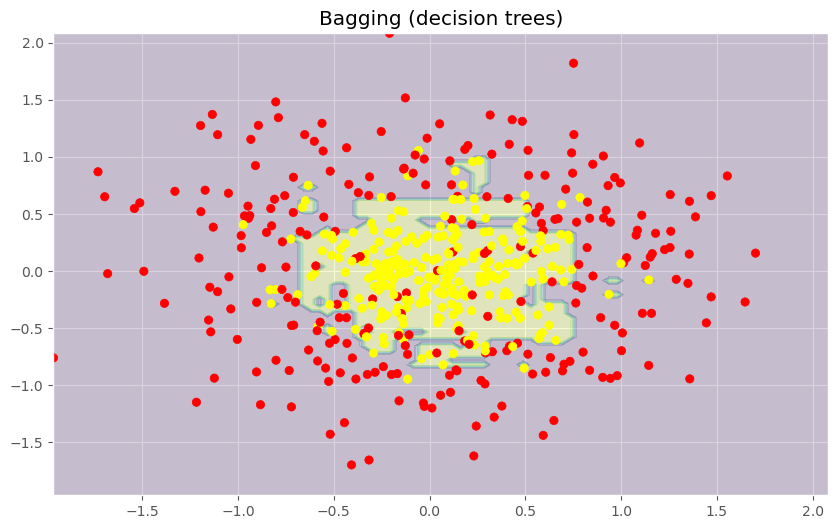

'\n这里预测的是从X的最小值到X的最大值里的所有,并且X的两个维度代表坐标,y是标签,代表是否在里面\n所以只用求x的范围,生成的网格就是x和y的范围.\n预测的话,预测的是所有x,y的值,所以要连接一下\npredict 传参一定是：(n_samples, n_features)\n\n'

In [133]:
b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300,random_state=42)
b_dtree.fit(X_train_circles,y_train_circles)

x_range = np.linspace(X.min(),X.max(),100)
xx1,xx2 = np.meshgrid(x_range,x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(),xx2.ravel()])
# y_hat = b_dtree.predict(xx1.ravel(),xx2.ravel())
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Bagging (decision trees)")
plt.show()
"""
这里预测的是从X的最小值到X的最大值里的所有,并且X的两个维度代表坐标,y是标签,代表是否在里面
所以只用求x的范围,生成的网格就是x和y的范围.
预测的话,预测的是所有x,y的值,所以要连接一下
predict 传参一定是：(n_samples, n_features)

"""

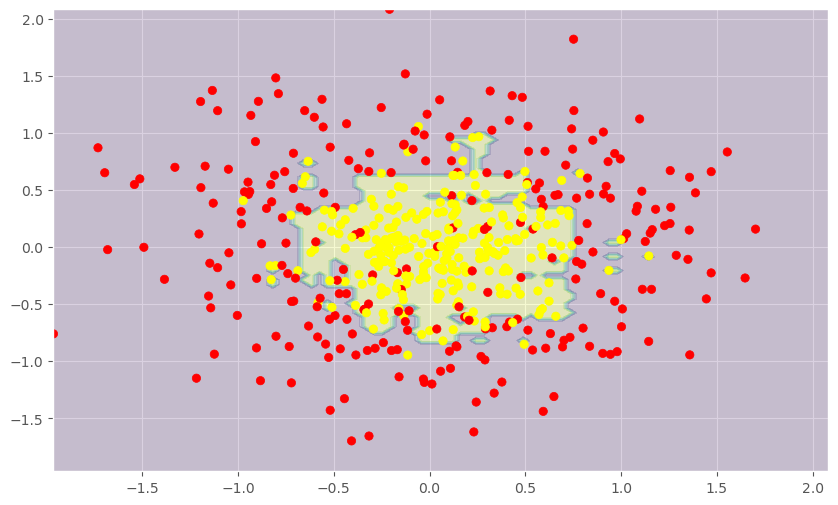

In [134]:
rf = RandomForestClassifier(n_estimators = 300,random_state = 42)
rf.fit(X_train_circles,y_train_circles)

x_range = np.linspace(X.min(),X.max(),100)
xx1,xx2 = np.meshgrid(x_range,x_range)
y_hat = rf.predict(np.c_[xx1.ravel(),xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)

plt.contourf(xx1,xx2,y_hat,alpha = 0.2)
plt.scatter(X[:,0],X[:,1],c = y,cmap = 'autumn')


上图显示了决策树形成的边界凹凸不平，有大量锐角，这暗示出现过拟合现象。相反，随机森林和 Bagging 的边界相当平滑，没有明显的过拟合的迹象。

**scikit-learn**库提供了 **BaggingRegresso**r** 和 **BaggingClassifier** 类，其中在创建新模型时需要注意的一些参数如下：   
- n_estimators 是随机森林中树的数量；
- criterion 是衡量分割质量的函数；
- max_features 是查找最佳分割时考虑的特征数；
- min_samples_leaf 是叶节点的最小样本数；
- max_depth 是树的最大深度。

**随机森林在现实问题中的应用**

首先，创建一个简单的分类器作为基线。出于简单的目的，只使用数值特征构建分类器。



In [135]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
df = pd.read_csv(
    "https://labfile.oss.aliyuncs.com/courses/1283/telecom_churn.csv")
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [136]:
# 选择数值特性
cols = []
for i in df.columns:
    if (df[i].dtype == 'float64') or (df[i].dtype=='int64'):
        cols.append(i)
cols

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

In [137]:
# 将数据集分离为输入变量和目标变量。
X,y = df[cols].copy(),np.asarray(df["Churn"],dtype = 'int8')

# 为验证过程进行分层分割。
skf = StratifiedKFold(n_splits=5,shuffle = True,random_state=42)

# 基于默认参数初始化分类器。
rfc = RandomForestClassifier(random_state = 42,n_jobs = -1,oob_score = True)
results = cross_val_score(rfc, X, y, cv=skf)
print("CV accuracy score: {:.2f}%".format(results.mean()*100))


CV accuracy score: 92.50%


In [138]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_acc=[]
test_acc = []
temp_train_acc = []
temp_test_acc = []

In [139]:
# 进行网格搜索。下方列表中候选数值较多，会增加线上环境执行时间，
# 可以自行减少数量以加快运行。

trees_grid = [5,10,15,20,30,50,75,100]


In [140]:
# 在训练集上训练模型。

for ntree in trees_grid:
    rfc = RandomForestClassifier(
        n_estimators=ntree,random_state=42,n_jobs = -1,oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # 这里X是DataFrame,y是numpy的数组
        rfc.fit(X_train,y_train)
        temp_train_acc.append(rfc.score(X_train,y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)      


In [141]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {}trees".format(max(test_acc.mean(axis=1))*100,
trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100trees


Text(0.5, 0, 'N_estimators')

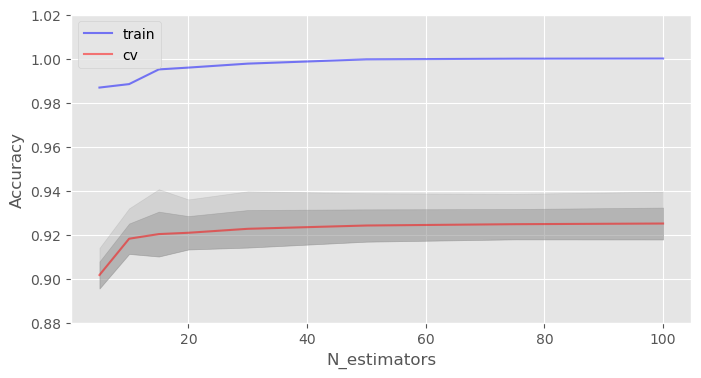

In [142]:
plt.style.use('ggplot')

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(trees_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
# 填充阴影,mean是均值，std是方差，这里是均值+-方差和均值加减2倍的方差
# 1倍显示主要波动范围，65%置信度
# 2倍显示极端波动范围，95%置信度
ax.fill_between(trees_grid,test_acc.mean(axis=1)-test_acc.std(axis=1),
                test_acc.mean(axis=1)+test_acc.std(axis=1),color = '#888888',
                alpha = 0.4)

ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid,test_acc.mean(axis=1)-test_acc.std(axis=1),
                test_acc.mean(axis=1)+2*test_acc.std(axis=1),color='#888888',
                alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")


上图表明，当树的数量增加到一定值时，测试集上的准确率不再提升，同时训练集上的准确率达到了 100%，这意味着出现过拟合。

为了避免过拟合，需要给模型加上正则化参数。下面将树的数目固定为 100，然后看看不同的 max_depth 效果如何，首先创建列表以保存训练和测试集上的准确率。

In [143]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3,5,7,9,11,13,15,17,20,22,24]

In [144]:
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(
        n_estimators=100,random_state = 42,n_jobs = -1,oob_score = True,
        max_depth = max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y[train_index],y[test_index]
        rfc.fit(X_train,y_train)
        temp_train_acc.append(rfc.score(X_train,y_train))
        temp_test_acc.append(rfc.score(X_test,y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)


Best accuracy on CV is 92.44% with 24 max_depth


Text(0.5, 0, 'Max_depth')

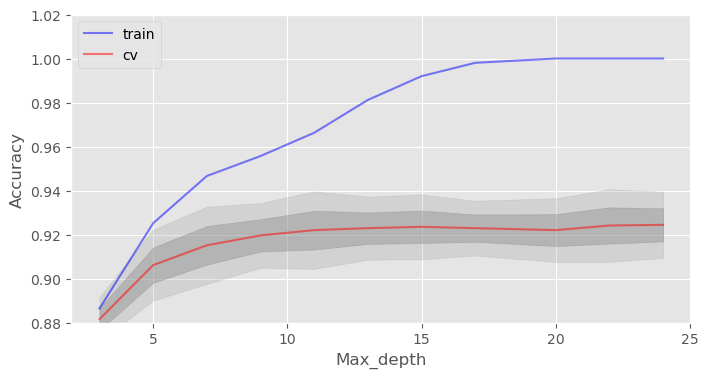

In [145]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100,
                                                                max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

max_depth 在模型中起到了正则化的作用，过拟合现象有所缓解，模型准确率提高了一些。

另一个值得调整的重要参数是 min_samples_leaf，它也能起到正则化作用。首先，创建列表以保存训练和测试集上的准确率。

In [146]:
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
test_acc = []
train_acc = []


In [148]:
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(
        n_estimators=100,min_samples_leaf = min_samples_leaf,n_jobs=-1,oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index ,test_index in skf.split(X,y):
        X_train,X_test  = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y[train_index],y[test_index]
        rfc.fit(X_train,y_train)
        temp_test_acc.append(rfc.score(X_test,y_test))
        temp_train_acc.append(rfc.score(X_train,y_train))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)


Best accuracy on CV is 92.41% with 3 min_samples_leaf


Text(0.5, 0, 'Min_samples_leaf')

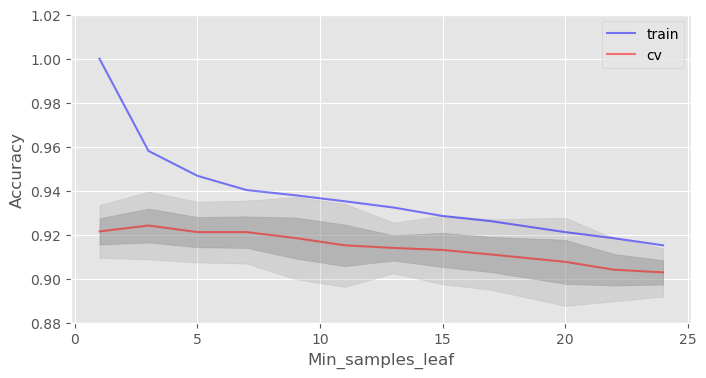

In [149]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100,
                                                                       min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(
    axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(
    axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

在这一情形下，验证集上的准确率没有提高，但当验证集的准确率保持 92% 以上时，过拟合的情况降低了 2%。

下面考虑 max_features 这一参数。在分类问题中，默认特征为「所有特征数的平方根」。首先，检查在这个例子中选择 4 个特征是否是最佳的，创建列表以保存训练和测试集的准确率。

In [150]:
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]
train_acc = []
test_acc = []

In [151]:
for max_features in max_features_grid:
    temp_test_acc = []
    temp_train_acc = []
    rfc = RandomForestClassifier(
        n_estimators=100,max_features=max_features,n_jobs=-1,oob_score=True,random_state=42
    )
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y[train_index],y[test_index]
        rfc.fit(X_train,y_train)
        temp_train_acc.append(rfc.score(X_train,y_train))
        temp_test_acc.append(rfc.score(X_test,y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)


Best accuracy on CV is 92.50% with 4 max_features


Text(0.5, 0, 'Max_features')

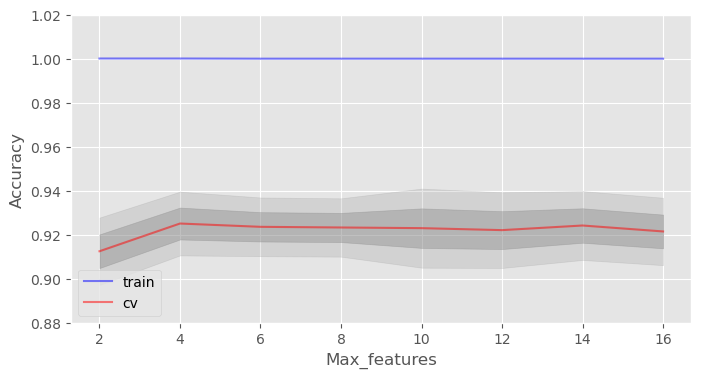

In [152]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100,
                                                                   max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

我们已经看到学习曲线如何随着基本参数的变化而变化。现在，直接使用 GridSearch() 来查找最佳参数。首先，初始化参数集以进行穷举搜索和拟合。

In [153]:
parameters = {'max_features':[10,13],'min_samples_leaf':[1,3],"max_depth":[5,10]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42,
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': [10, 13],
                         'min_samples_leaf': [1, 3]},
             verbose=1)

In [154]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True, random_state=42),
 0.9246971109040075)

# 特征的重要性


In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [157]:
hostel_data = pd.read_csv(
    "https://labfile.oss.aliyuncs.com/courses/1283/hostel_factors.csv")
features = {"f1": u"Staff",
            "f2": u"Hostel booking",
            "f3": u"Check-in and check-out",
            "f4": u"Room condition",
            "f5": u"Shared kitchen condition",
            "f6": u"Shared space condition",
            "f7": u"Extra services",
            "f8": u"General conditions & conveniences",
            "f9": u"Value for money",
            "f10": u"Customer Co-creation"}
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [158]:
forest = RandomForestRegressor(n_estimators=100,max_features=10,random_state=0)
forest.fit(hostel_data.drop(['hostel','rating'],axis=1),hostel_data['rating'])
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [159]:
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

Feature ranking:
1. Staff 0.210751 
2. Value for money 0.175066 
3. Customer Co-creation 0.122167 
4. Shared space condition 0.112113 
5. Extra services 0.081404 
6. General conditions & conveniences 0.074633 
7. Check-in and check-out 0.072012 
8. Hostel booking 0.059564 
9. Shared kitchen condition 0.053865 
10. Room condition 0.038425 


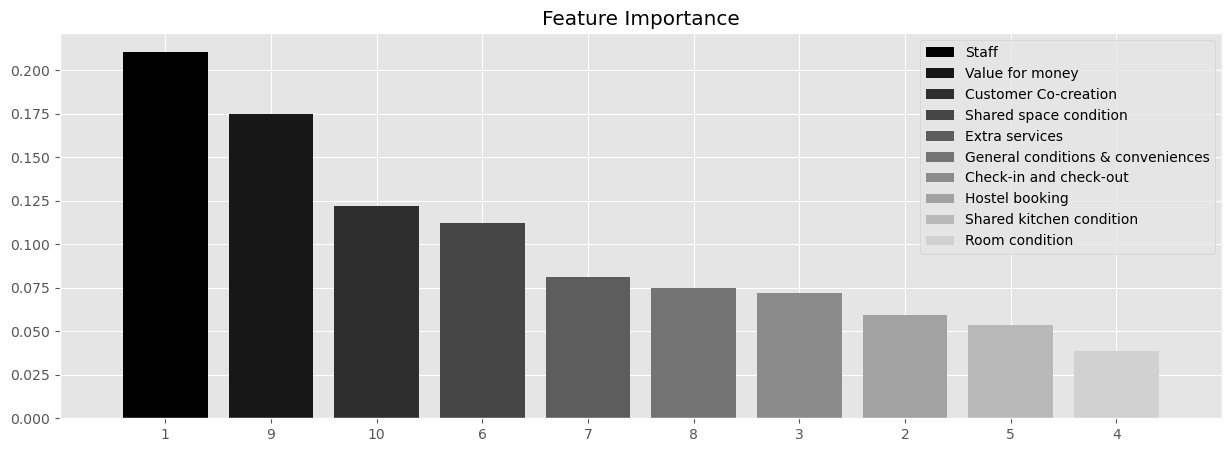

In [160]:
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1,
                          features["f"+str(feature_indices[f])],
                          importances[indices[f]]))
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot),
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1))
                       for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot),
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)])
                  for i in feature_indices])